# Expansiones Basales y Nolinealidades

> __Alcance de la lectura:__
> * Entender los conceptos asociados al tratamiento de nolinealidades a través de expansiones de base.
> * Ser capaz de implementar modelos aditivos generalizados.
> * Comprender la importancia de los hiperparámetros de un modelo y las dificultades asociadas a su elección.
> * Entender la importancia de las transformaciones no lineales de atributos.

---

# Motivación

En vista a nuestros conocimientos sobre regresión lineal y regularizadores, una pregunta común es ¿Por qué a pesar de sus limitantes, existe tanta teoría asociada a la regresión lineal? Ya sabemos que la regresión busca presentar una recta de mejor ajuste que resume un punto característico en un invervalo de datos.  Una de las principales limitantes de ésta aproximación es la forma funcional que impone un alto sesgo en nuestros datos de entrenamiento. Existen medidas paleativas como implementar términos polinomiales y/o splines, que implica dedicar parte importante en investigar cuál es la mejor representación funcional __en los datos de entrenamiento__. 

Un contrapunto asociado al uso de splines o términos polinomiales en el componente sistemático de nuestra regresión es la probabilidad de generar un ajuste perfecto en los datos que ya tenemos conocimiento. Lo que necesitamos es un método que permita __describir el comportamiento general de un fenómeno con un márgen de error controlado__. Nuestro objetivo como investigadores no es generar predicciones perfectas con un desempeño perfecto, lo que intentamos es generar predicciones con un nivel de certeza __cercano__ al 100%.

Tener un modelo entrenado con un desempeño alto __no es condición suficiente para su validación externa y asegurar conocimiento sobre el fenómeno estudiado__. Este comportamiento puede generar falsa seguridad en el investigador, generando supuestos falsos sobre el modelo. Aspectos como la causalidad entre atributos y el vector obetivo no se puede asegurar mediante las métricas de desempeño. Con el advenimiento de métodos de caja negra, esto se transforma en un arma de doble filo.

Los Modelos Aditivos Generalizados buscan superar las limitantes impuestas de la forma funcional de los modelos lineales (sean en su variante generalizada o normal). La rigidez de asumir un comportamiento lineal fijo para todo atributo en nuestro conjunto de datos genera situaciones donde la forma funcional presenta un alto sesgo y no captura de manera adecuada el comportamiento del modelo.

Sabemos que en una regresión lineal buscamos resolver una ecuación con forma $y=\beta_{0}+\mathbf{X}\vec{\beta}$. El principal problema con esa forma es que asume monotonicidad estricta tanto en X como en Y. Una de las primeras soluciones es especificar la forma funcional en el modelo mediante la inclusión de términos polinomiales. El problema con la implementación de términos polinomiales es que la optimización de la función objetivo dependará fuertemente de los datos, restringiendo su capacidad de generalización.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import lec2_graphs as afx
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams["figure.figsize"] = (10, 6) # Tamaño gráficos
plt.rcParams["figure.dpi"] = 80 # resolución gráficos
sns.set_style('darkgrid')

afx.polynomial_degrees()

La figura generada con `afx.polynomial_degrees()` presenta la recta de ajuste en una serie de datos con una fuerte no linealidad. Cada uno de los gráficos representa la inclusión de términos en el lado derecho de la ecuación. La cantidad de términos está representado con el operador $\sum_{j=1}^{T}$. Una regresión sin térmimos falla en capturar gran parte de la dinámica. En el extremo opuesto, cuando agregamos alrededor de 20 términos, nuestra curva se adapta muy bien en los datos existentes, pero no tenemos certeza sobre cómo serán los siguientes datos que deseamos predecir. El óptimo se encuentra entre 3 y 5 polinomios, dado que se ajustan relativamente bien a los datos mientras no exacerban la varianza (representada con el área sombreada de los intervalos de confianza).

Otra solución es mediante los Modelos Lineales Generalizados. Con esta familia de modelos podemos incorporar otras distribuciones en nuestro vector objetivo, e incluír una función de vínculo que permita asociada los valores esperados de $\mathbb{E}[y]$ con una combinación lineal de parámetros $\mathbf{X}\vec{\beta}$. Con esta estrategia podemos caputar un proceso de generación de datos distinta a la requerida por la regresión lineal, pero no hemos trabajado sobre la restricción monotónica de los parámetros. 


> __Digresión__: GAM vs. OLS
>
> Si los Modelos Aditivos Generalizados presentan tantas virtudes, ¿por qué seguimos implementando el modelo de regresión lineal?
> Cosma Shalizi (NA) sugiere la existencia de dos razones por las cuales preferimos modelos lineales:
> * Por lo general los análisis se guían por teoría científica que asume el comportamiento entre variables como lineal. 
> * Desde la eficiencia computacional, cuando incluímos términos distintos a los lineales estamos aumentando la complejidad del modelo, que muchas veces repercute en tiempo y recursos de procesamiento.
> En una gran parte de los casos cuando se implementan modelos, ninguno de los puntos son justificables: La teoría no nos dice que debemos esperar linealidad estricta (y muchas veces, un buen primer paso es la exploración de éste supuesto en los datos), y hoy en día el poder computacional es lo suficientemente alto como para ejecutar modelos con una mayor complejidad en minutos. 
La gente implementa modelos lineales porque no tiene los elementos necesarios como para sentirse cómoda implementando GAM.

----

# Modelos Aditivos Generalizados (Generalized Additive Models)


Los Modelos Aditivos Generalizados surgen como un compromiso entre ambas soluciones, partiendo del supuesto que nuestra función de regresión candidata es __desconocida__ (Hastie et al. 2009).
La forma general de los GAMs es:

$$
g(\mathbb{E}(Y)) = \beta_0 + f_1(x_1) + f_2(x_2) + ... + f_m(x_m)
$$

Donde:
* $\beta_0$ es el intercepto.
* $g( \cdot )$ es llamada *función de vínculo* que permite relacionar el valor esperado de la variable objetivo con las variables predictivas ($x_i$).
* $f_i(x_i)$ es el output de la i-ésima función (spline) sobre el i-ésimo atributo.

La forma de los GAMs es bastante similar a la de un modelo lineal. La diferencia es que en un modelo lineal todas las funciones $f_i( \cdot )$ son las funciones de identidad. La potencia de los GAMs radica en la posibilidad de utilizar distintas funciones para tratar de distinta manera ciertos atributos, por ejemplo, a través de funciones no lineales. La no linealidad permite a la curva de regresión responder de forma mucho más flexible a oscilaciones periódicas o fluctuaciones en la variable objetivo.



## Entrenamiento de GAMs
Ya tenemos la formulación del modelo, ahora tenemos que especificar como aprenderá, esto lo hacemos especificando una función de costo y pérdida. El método que utilizará el modelo para aprender sus parámetros por lo general no se considera parte del modelo pues es una de las decisiones que uno debe tomar. Un modelo puede aprender sus parámetros utilizando muchos métodos distintos, el resultado (en teoría), debiése ser el mismo.

Los GAMs clásicos buscan estimar las funciones $f_i(\cdot)$ mediante la minimización de la siguiente función objetivo:

$$
\underset{\hat{f_i}}{\textsf{argmin}} \sum_{i = 1}^{n} (y_i - \sum_{j = 1}^{p} f_{j}(x_{i,j}))^2 + \lambda \sum_{j}^{p} \int f_{j}''(t)^2dt
$$

Si nos fijamos bien, el término de penalización (el de la derecha) está penalizando la concavidad de la spline, si la spline es muy *"exagerada"* se penalizará más, de hecho, si la spline es una linea recta el modelo no es penalizado. El factor $\lambda$ es el coeficiente de *tradeoff* entre la concavidad de la spline propuesta y la penalización asignada, mientrás más alto este hiperparámetro, más se penalizará el modelo por las splines que sean curvas y tenderá a splines más rectas.

La penalización a la segunda derivada de la spline es una forma de evitar el overfitting al que suelen tender las splines.


> __Digresión__: ¿Cómo obtenemos las funciones de identidad?
>
> Hasta ahora asumimos que las funciones de vínculo existen y permiten suavizar cada término, ignorando cómo se obtienen.
> Un problema frecuente con este modelo es que el término constante $\beta_{0}$ no es identificable (esto es que no tiene una solución única), dificultando la obtención de estimaciones y sus funciones correspondientes.
> Para facilitar la obtención, Hastie et al. (2009) reportan el uso del algoritmo __Backfitting__. A grandes rasgos, el algoritmo busca lo siguiente:
> 1. Asumimos que $\beta_{0}$ no es identificable, lo igualamos al promedio de las observaciones de $y$.
> - Aplicamos una función de suavización a $x_i$ para estimar los vectores objetivos y obtener un suavizador candidato $\hat{f}_{k}$
> - Actualizamos el valor de $\beta_{0}$ en base al paso 2.
> - Iteramos los pasos 2 y 3 hasta que $\hat{f}_{k}$ se estabilice o satisfaga algún criterio de tolerancia.


## Implementando un Modelo Aditivo Generalizado con `pygam`

Para implementar nuestro modelo GAM, utilizaremos la librería `pygam`. Por defecto, ésta no viene incluída por defecto en la distribución de Anaconda y debemos incorporarla de la siguiente manera: `conda install -c conda-forge pygam`. Una vez instalada, procedemos con los pasos usuales:

Para este ejemplo trabajaremos con la base de datos sobre los precios de inmuebles en Boston que implementamos en la lectura de Regularización Paramétrica, y generaremos un procedimiento de limpieza idéntico al de esa lectura.

In [3]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('kc_house_data.csv')
# Vamos a eliminar ciertas columnas que son irrelevantes para nuestro analisis
df.drop(['zipcode', 'id', 'date'], axis = 1, inplace = True)
# Normalizamos la variable precio
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)
df_scaled['price'] = np.log(df['price'])

También generaremos las muestras de entrenamiento y validación, dejando un 30% de la muestra reservada para validar el modelo

In [4]:
from sklearn.model_selection import train_test_split
# X será nuestro conjunto de atributos e y será nuetra variable objetivo

X = df_scaled.iloc[:, 1:] # Tomamos todas las columnas menos la primera (price)
N = X.shape[0] # guardamos el número de filas (datos de entrenamiento)
X.insert(X.shape[1], 'intercept', np.ones(N)) #Se crea una columna nueva dentro de las variables predictoras llamada 'intecept'
y = df_scaled['price'] # asignamos como target la variable 'price'

#Separamos los subsets de test y train
X_train, X_test, y_train, y_test,  = train_test_split(X, y, test_size = 0.3, random_state = 63)

En la lectura de regularización paramétrica aprendimos sobre la importancia de seleccionar hiperparámetros para obtener un modelo con mejor desempeño. Por suerte para nosotros, la librería `pyGAM` implementa un método de búsqueda de hiperparámetros que nos ahorra el trabajo de explorar a mano las combinaciones. El método `gridsearch` solicita un diccionario que se pasa posteriormente como _keyword argument_, donde la llave es el nombre del parámetro (en este caso, `lam`) y un rango de valores a evaluar (en este caso, `np.logspace(-3, 3, 11)`).

Aprovechando la facilidad de especificar el proceso de generación de datos, importamos la clase `LinearGAM` de `pygam`. Otras opciones incluyen la Binomial, Poisson, Gamma, Gaussiana Inversa y funciones de vínculo. La API ofrece una clase prototipo `GAM` para desarrollar modelos personalizados. 

In [5]:
from pygam import LinearGAM

# definimos el rango de hiperparámetros a evaluar
search_params = {'lam': np.logspace(-3, 3, 11)}
# Creamos el modelo, lo entrenamos y buscamos los hiperparámetros mediante gridsearch
gam = LinearGAM().gridsearch(X_train, y_train, **search_params)

100% (11 of 11) |########################| Elapsed Time: 0:00:38 Time:  0:00:38


Cuando generamos la búsqueda de hiperparámetros en la grilla definida con `search_params`, el objeto generado guardará las estimaciones del modelo en consideración al mejor valor de lambda.

In [7]:
print("Mejor valor de lambda: {}".format(gam.lam))

Mejor valor de lambda: 3.981071705534969


In [8]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    156.1823
Link Function:                     IdentityLink Log Likelihood:                               -162761.3469
Number of Samples:                        15129 AIC:                                           325837.0584
                                                AICc:                                            325840.38
                                                GCV:                                                0.0384
                                                Scale:                                              0.0377
                                                Pseudo R-Squared:                                   0.8671
Feature Function   Data Type      Num

El método `summary()` nos entrega una descripción detallada del modelo:

* Podemos ver que para todos los atributos el *p-value* obtenido es considerablemente pequeño por lo que no tendremos que preocuparnos por descartarlos en este caso. 
* La tabla de resultados nos dice que el modelo fue entrenado utilizando 25 splines, cada una de orden 3.
* A cada spline se le asignó el mismo coeficiente de penalización $\lambda=3.981$

El modelo obtuvo un pseudo R-squared de 0.8671, lo cual es bastante bueno en comparación con los valores que obtuvimos en regularizadores del modelo lineal (donde el coeficiente de determinación era del .67%). Para evaluar el desempeño del modelo, podemos implementar las funciones de métricas de `sklearn`. Para este caso importaremos `r2_score`, `mean_squared_error` y `median_absolute_error`. Posteriormente los compararemos con otras especificaciones del modelo.

In [9]:
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
print('Test R^2 accuracy: {0}'.format(r2_score(y_test, gam.predict(X_test)).round(3)))
print('Test RMSE accuracy: {0}'.format(np.sqrt(mean_squared_error(y_test, gam.predict(X_test))).round(3)))
print('Test MAE accuracy: {0}'.format(median_absolute_error(y_test, gam.predict(X_test)).round(3)))

Test R^2 accuracy: 0.854
Test RMSE accuracy: 0.198
Test MAE accuracy: 0.112


Una de las principales ventajas de implementar modelos aditivos,  es que al ser las derivadas parciales linealmente independientes entre los aributos predictores, podemos estudiar el comportamiento y respuesta de la predicción con respecto a cada atributo por separado si mantenemos los demás atributos fijos como su media. `pyGAM` nos permite hacer esto por medio del método `partial_dependence()` que presenta la evaluación de la función de suavización para cada uno de los atributos. Mediante esta forma generaremos una interpretación visual del modelo.

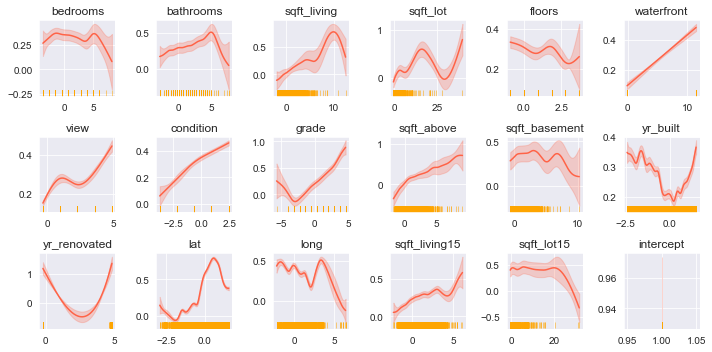

In [10]:
from pygam.utils import generate_X_grid

# mediante generate_X_grid vamos a generar un array que contenga los valores de cada atributo
x_grid = generate_X_grid(gam)
plt.figure(figsize=(10,5))
attribute = X_train.columns
# generamos el dimensionado del grid en base a la cantidad de atributos
cols = 6; rows = int(len(attribute) / cols)

# para cada atributo
for i, n in enumerate(range(len(attribute))):
#     print(X_train[attribute[n]])
    plt.subplot(rows, cols, i + 1)
    # extraemos la dependencia parcial y sus intervalos de confianza al 95%
    partial_dep, confidence_intervals = gam.partial_dependence(x_grid, feature = i + 1, width=.95)
    # Visualizamos la recta
    plt.plot(x_grid[:, n], partial_dep, color='tomato')
    # Generamos una visualización de los intervalos de confianza
    plt.fill_between(x_grid[:, n],
                     confidence_intervals[0][:, 0],
                     confidence_intervals[0][:, 1],
                     color='tomato', alpha=.25)
    # agregamos el nombre del atributo
    plt.title(attribute[n])
    plt.plot(X_train[attribute[n]], 
             [plt.ylim()[0]] * len(X_train[attribute[n]]),
             '|', color='orange', alpha=.5)
plt.tight_layout()

Analicemos algunos comportamientos interesantes:

* El precio de la vivienda (`price`) y el número de pisos (`floors`) que tiene parecen estar fuertemente relacionados de forma lineal, lo mismo ocurre para la calidad de la vista que tiene la vivienda.
* La condición en la que se encuentra la casa (`condition`) parece aportar linealmente al precio luego de cierto punto, puede ser que antes del mínimo de la curva, para viviendas en malas condiciones, su precio se deba más a la calidad del terreno en lugar de la vivienda en sí.
* El año de construcción de las viviendas (`yr_built`) tiene un único mínimo y es convexa, lo que es interesante pues hay grupos de viviendas cuyo valor puede estar dado principalmente por las remodelaciones o conservación de patrimonio.

Hay varias curvas cuyo comportamiento cambia bastante a lo largo de sus dominios. El parámetro de penalización ($\lambda$) también nos permite modificar qué tanto de la tendencia general y de la tendencia particular de la data se ve reflejada en las curvas. Veamos como cambian las curvas de dependencia al modificar el valor de $\lambda$:

In [11]:
new_gam = LinearGAM(lam = 1e3)
new_gam.fit(X_train, y_train)
print('Test R^2 accuracy: {0}'.format(r2_score(y_test, new_gam.predict(X_test)).round(3)))
print('Test RMSE accuracy: {0}'.format(np.sqrt(mean_squared_error(y_test, new_gam.predict(X_test))).round(3)))
print('Test MAE accuracy: {0}'.format(median_absolute_error(y_test, new_gam.predict(X_test)).round(3)))

Test R^2 accuracy: 0.851
Test RMSE accuracy: 0.2
Test MAE accuracy: 0.116


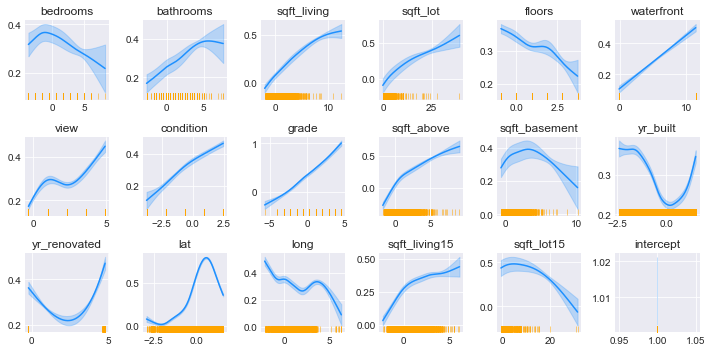

In [40]:
x_grid = generate_X_grid(new_gam)
plt.rcParams['figure.figsize'] = (10, 5)
attribute = X_train.columns
cols = 6; rows = int(len(attribute) / cols)

for i, n in enumerate(range(len(attribute))):
    plt.subplot(rows, cols, i + 1)
    partial_dep, confidence_intervals = new_gam.partial_dependence(x_grid, feature = i + 1, width=.95)
    plt.plot(x_grid[:, n], partial_dep, color='dodgerblue')
    plt.fill_between(x_grid[:, n],
                     confidence_intervals[0][:, 0],
                     confidence_intervals[0][:, 1],
                     color='dodgerblue', alpha=.25)
    plt.title(attribute[n])
    plt.plot(X_train[attribute[n]],
             [plt.ylim()[0]] * len(X_train[attribute[n]]),
             '|', color='orange', alpha=.5)
plt.tight_layout()

De hecho, podemos aumentar tanto la penalización a la segunda derivada que las curvas de dependencia pueden volverse rectas:

In [12]:
new_gam2 = LinearGAM(lam = 1e9)
new_gam2.fit(X_train, y_train)  
print('Test R^2 accuracy: {0}'.format(r2_score(y_test, new_gam2.predict(X_test))))
print('Test RMSE accuracy: {0}'.format(np.sqrt(mean_squared_error(y_test, new_gam2.predict(X_test)))))
print('Test MAE accuracy: {0}'.format(median_absolute_error(y_test, new_gam2.predict(X_test))))

Test R^2 accuracy: 0.7685470290065978
Test RMSE accuracy: 0.24962273588195977
Test MAE accuracy: 0.1569901511960392


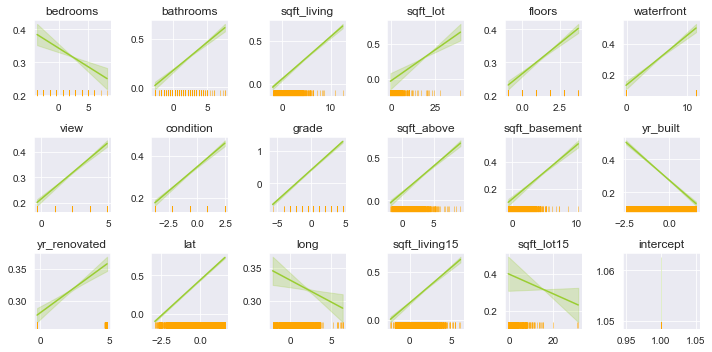

In [13]:
x_grid = generate_X_grid(new_gam2)
plt.rcParams['figure.figsize'] = (10, 5)
attribute = X_train.columns
cols = 6; rows = int(len(attribute) / cols)

for i, n in enumerate(range(len(attribute))):
    plt.subplot(rows, cols, i + 1)
    partial_dep, confidence_intervals = new_gam2.partial_dependence(x_grid, feature = i + 1, width=.95)
    plt.plot(x_grid[:, n], partial_dep, color='yellowgreen')
    plt.fill_between(x_grid[:, n], 
                     confidence_intervals[0][:, 0],
                     confidence_intervals[0][:, 1],
                     color='yellowgreen', alpha=.25)
    plt.title(attribute[n])
    plt.plot(X_train[attribute[n]],
             [plt.ylim()[0]] * len(X_train[attribute[n]]),
             '|', color='orange', alpha=.5)
plt.tight_layout()

Las rectas reflejan muy a groso modo la tendencia general de la curva de dependencia. Por lo general, eligiremos un factor de penalización que permita *"amortiguar"* los comportamientos oscilatorios extremos y repetitivos, pero evitando las rectas, que sabemos que son demasiado ingénuas para modelar casi cualquier fenómeno de la vida real.

Al comparar las métricas de desempeño de los modelos, encontramos evidencia en contra de generar un modelo que penalice de manera fuerte los coeficientes. Mientras que en los modelos $\lambda=3.98$ y $\lambda=1e3$ las métricas de desempeño son casi idénticas, para el caso cuando $\lambda=1e9$ el desempeño empeora en todos los indicadores.

# Usos 

* Hastie et al. (2009) sugieren que los modelos aditivos generalizados se pueden implementar para la generación de pronósticos en series de tiempo. Dado que el algoritmo Backfitting permite la reducción del error en las funciones de suavización aditivas. El equipo de Data Science de Facebook creó `prophet`, una librería para la automatización de pronósticos en series de tiempo mediante GAM. Pueden encontrar más información en el siguiente link: https://github.com/facebook/prophet .

# Referencias 

* Una introducción exhaustiva respecto a los modelos generalizados aditivos se encuentra en Wood, S. 2017. Generalized Additive Models: An Introduction with R. Texts in Statistical Science. Boca Raton, FL: CRC Press. El capítulo 3: Introducing GAMs presenta los principales elementos analíticos y aspectos formales de los GAM.
* Para profundizar sobre las nolinealidades en puntos fijos en la combinación lineal de parámetros se recomienda leer Marsh, L; Cormier, D. 2001. Spline Regression Models. Quantitative applications in the Social Sciences.
* Los vínculos existentes entre el aprendizaje automatizado y los modelos nolineales en $X$ se detallan en Hastie, T; Tibshirani, T; Friedman, J. 2008. The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics. Springer. Ch5: Basis Expansions and Regularization.